# Fibonacci Strategies

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.lib import plot_heatmaps, resample_apply
import matplotlib.pyplot as plt
from util.ATR import ATR
from util.SMA import SMA
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Fibonacci import Fibonacci , PrepareData



## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Fibonacci

In [6]:
account_size = 20000

## Prepare Data

In [7]:
data_D1 = PrepareData(XAUUSD['D1'])
data_H4 = PrepareData(XAUUSD['H4'])
data_H1 = PrepareData(XAUUSD['H1'])
data_M30 = PrepareData(XAUUSD['M30'])
data_M15 = PrepareData(XAUUSD['M15'])
data_M5 = PrepareData(XAUUSD['M5'])
data_M1 = PrepareData(XAUUSD['M1'])

KeyboardInterrupt: 

# Backtest each time frame

## TF D1

In [ ]:
Backtest_D1 = Backtest(data_D1, strategy, cash=account_size, margin=1/2000, )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 16:00:00
End                       2023-03-10 00:00:00
Duration                   5911 days 08:00:00
Exposure Time [%]                    99.97025
Equity Final [$]                    19464.729
Equity Peak [$]                     21795.822
Return [%]                          -2.676355
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.168028
Volatility (Ann.) [%]                3.829592
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.972111
Avg. Drawdown [%]                   -0.899529
Max. Drawdown Duration     4203 days 08:00:00
Avg. Drawdown Duration      119 days 15:00:00
# Trades                                 6054
Win Rate [%]                        43.657086
Best Trade [%]                      11.735448
Worst Trade [%]                     -9.290183
Avg. Trade [%]                    

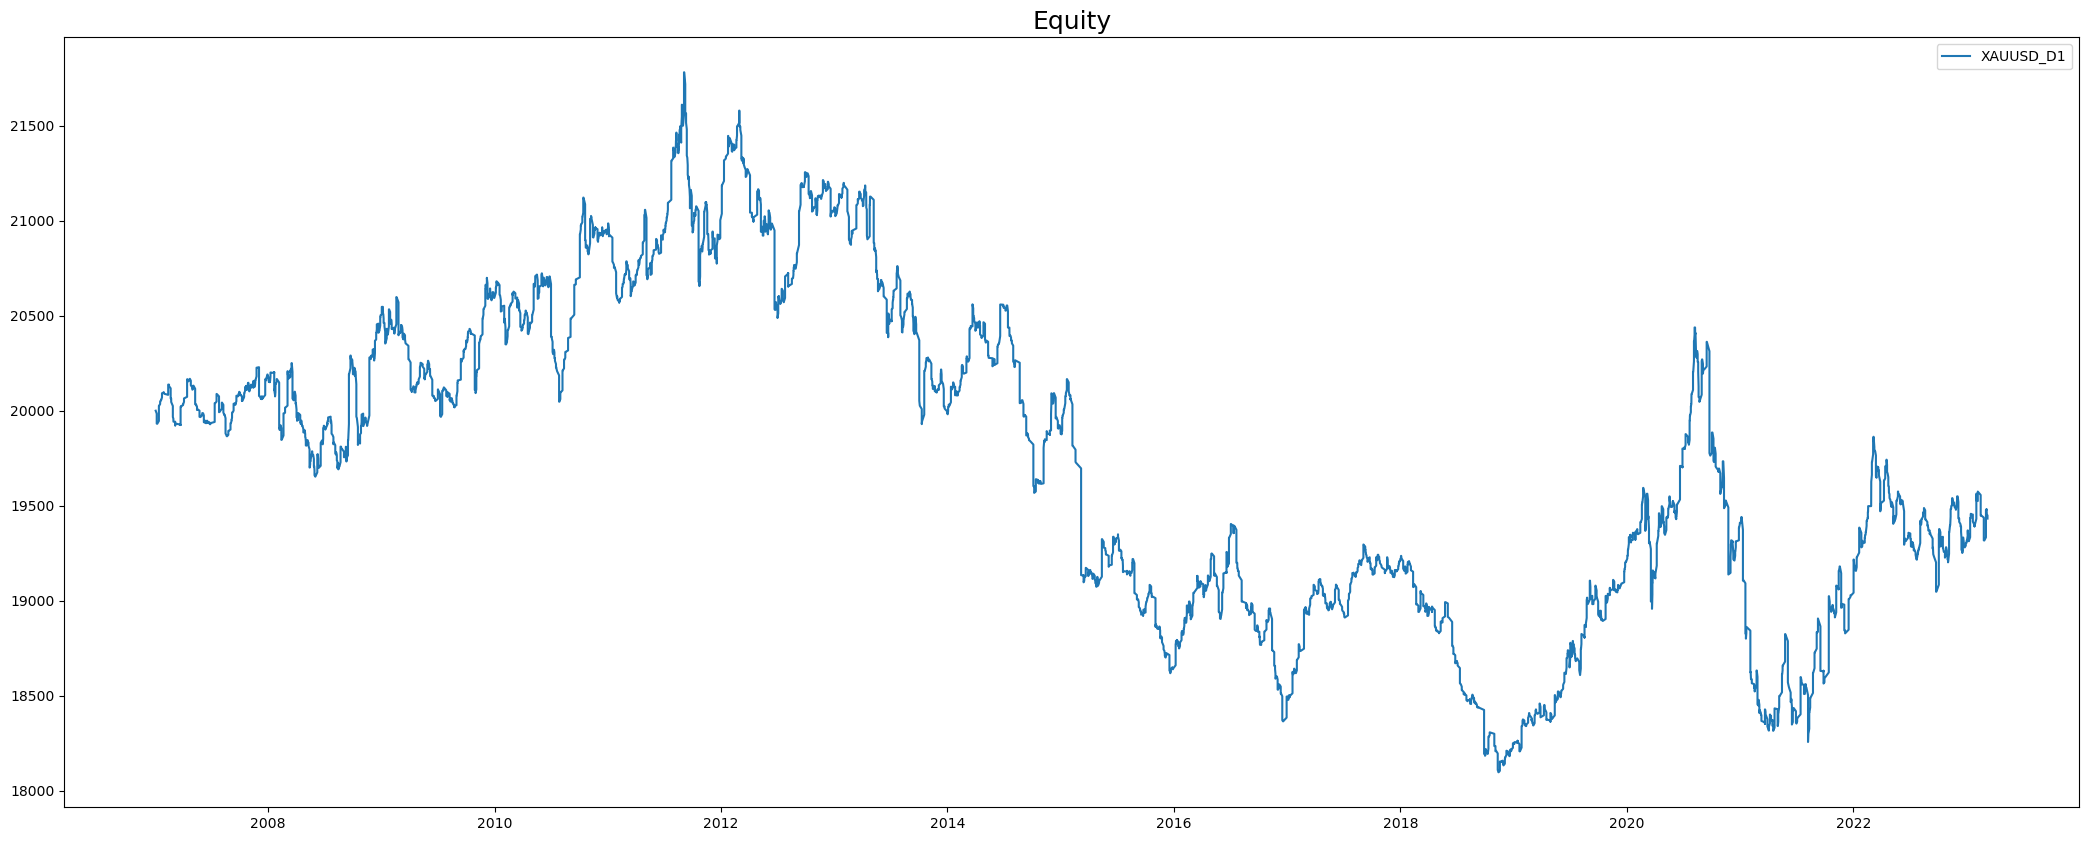

In [ ]:
plot_equity_trades(result_D1['_trades'],'XAUUSD_D1' , account_size)

## TF H4

In [ ]:
Backtest_H4 = Backtest(data_H4, strategy,
                       cash=account_size, margin=1/2000, )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 16:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.992545
Equity Final [$]                    34202.886
Equity Peak [$]                     34202.886
Return [%]                           71.01443
Buy & Hold Return [%]              193.102239
Return (Ann.) [%]                    2.716471
Volatility (Ann.) [%]                4.457193
Sharpe Ratio                         0.609458
Sortino Ratio                        0.923667
Calmar Ratio                         0.336128
Max. Drawdown [%]                   -8.081667
Avg. Drawdown [%]                   -0.463613
Max. Drawdown Duration     1463 days 16:00:00
Avg. Drawdown Duration       22 days 07:00:00
# Trades                                16576
Win Rate [%]                        52.431226
Best Trade [%]                      12.298778
Worst Trade [%]                     -7.257647
Avg. Trade [%]                    

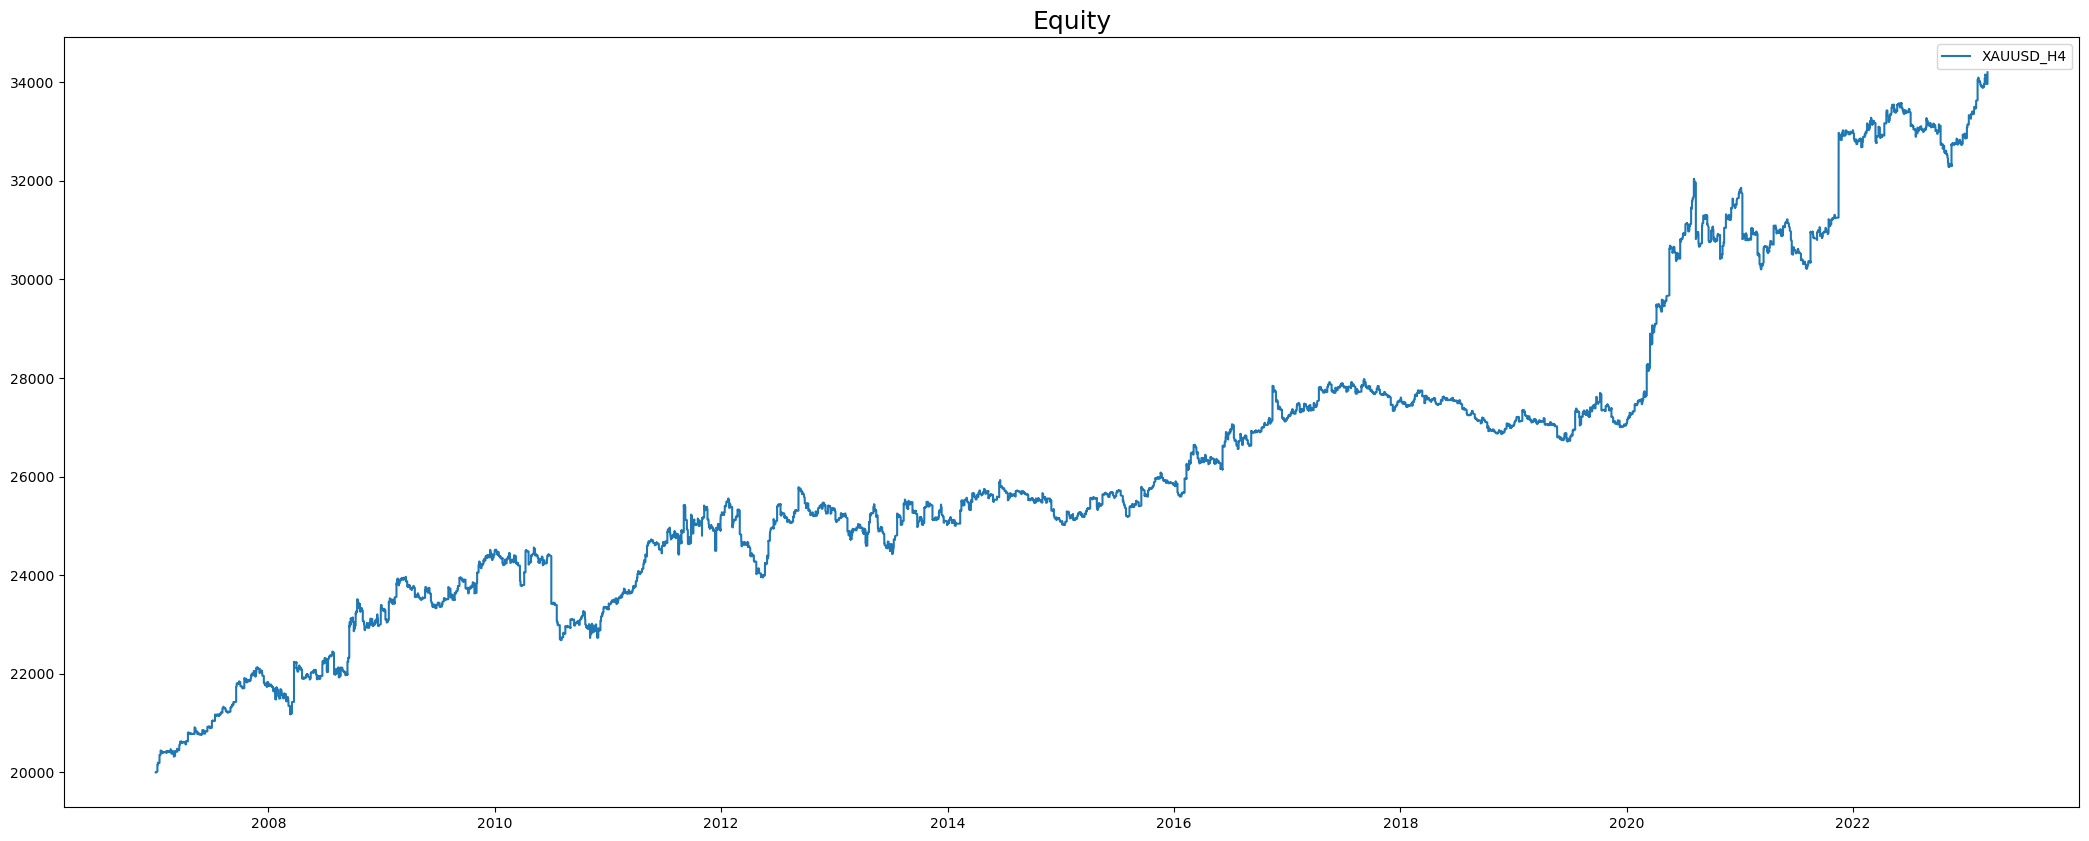

In [ ]:
plot_equity_trades(result_H4['_trades'], 'XAUUSD_H4' , account_size)

## TF H1

In [ ]:
Backtest_H1 = Backtest(data_H1, strategy,
                       cash=account_size, margin=1/2000, )
result_H1 = Backtest_H1.run()
result_H1

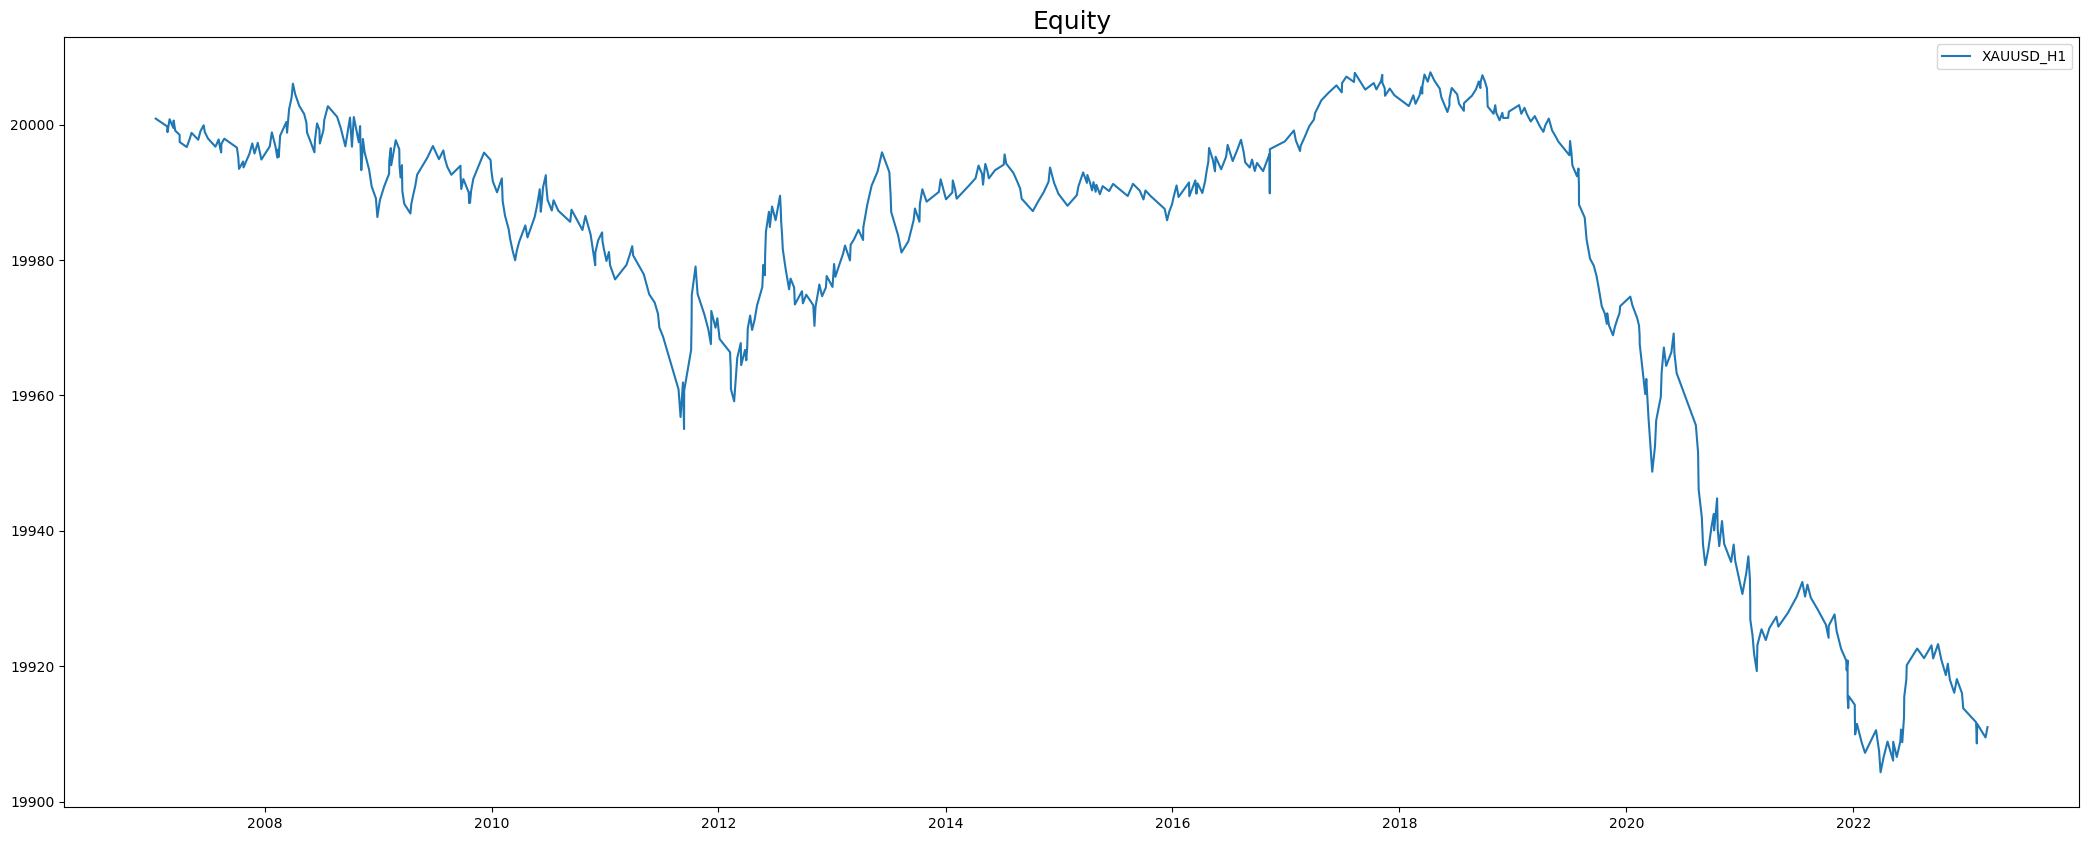

In [ ]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

## TF M30 

In [ ]:
Backtest_M30 = Backtest(data_M30, strategy,
                       cash=account_size, margin=1/2000, )
result_M30 = Backtest_M30.run()
result_M30

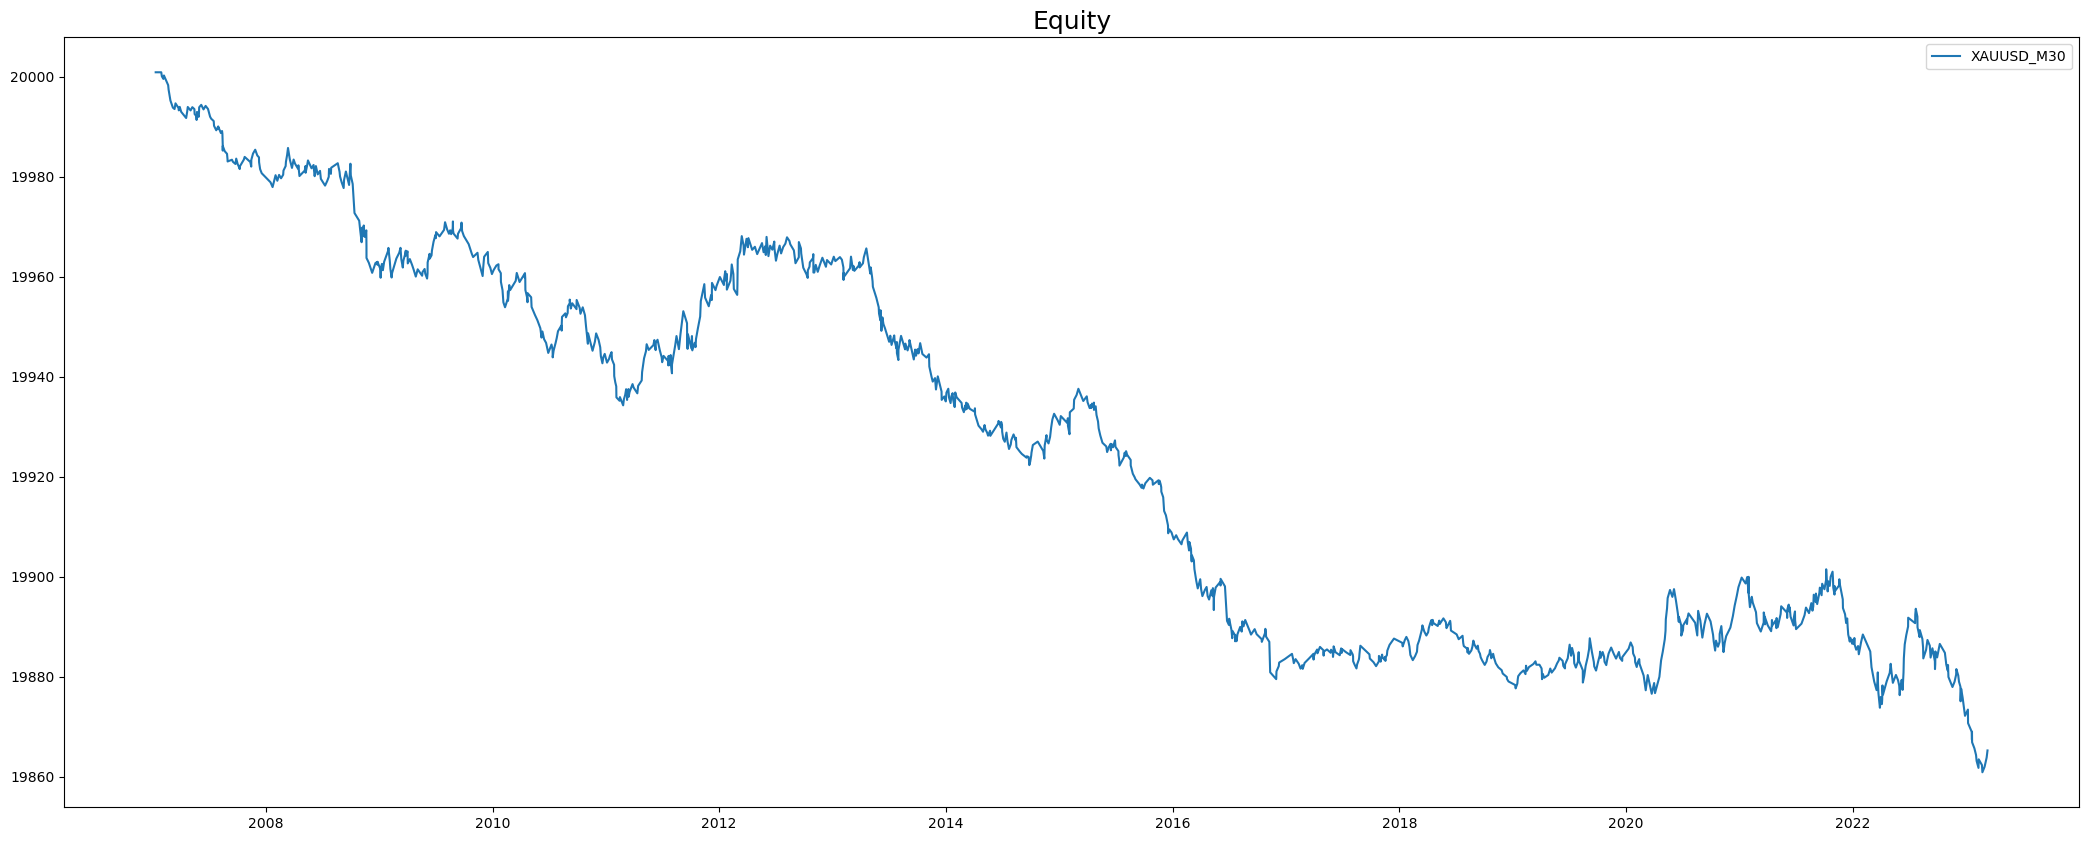

In [ ]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)